# 06 - Weather time series modeling
Stationarity checks, ACF/PACF, ARIMA/SARIMA grid search, and ML regressors with explicit lags/rolling features on the 3h temperature series.

In [23]:
from pathlib import Path
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from Model.time_series import (
    FeatureBuilder,
    OpenMeteoHistoricalRepository,
    TimeSeriesPreprocessor,
    WeatherQuery,
    ARIMAModel,
    SARIMAModel,
    SARIMAXModel,
    RegressionModel,
    GradientBoostingModel,
    compute_metrics,
    train_test_split_time,
)

## Load data (from CSV or fetch fresh)
Prefers the processed 3h dataset saved by notebook 05.

In [24]:
CITY = 'Ajaccio'
LATITUDE = 41.5536
LONGITUDE = 8.4413
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
DATA_PATH = PROJECT_ROOT / 'Data' / 'processed' / f'weather_{CITY.lower()}_3h.csv'

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
else:
    repo = OpenMeteoHistoricalRepository(default_hourly=['temperature_2m'])
    query = WeatherQuery(latitude=LATITUDE, longitude=LONGITUDE, start_date=START_DATE, end_date=END_DATE)
    raw_df, _ = repo.fetch(query)
    preproc = TimeSeriesPreprocessor(step_hours=3)
    df = preproc.run(raw_df)
df['date'] = pd.to_datetime(df['date'], utc=True)
df = df.sort_values('date').reset_index(drop=True)
df.head()

,temperature_2m,date
0,5.563334,2014-01-01 00:00:00+00:00
1,4.863334,2014-01-01 03:00:00+00:00
2,4.980000,2014-01-01 06:00:00+00:00
3,7.413333,2014-01-01 09:00:00+00:00
4,9.213333,2014-01-01 12:00:00+00:00


## Stationarity (ADF/KPSS) and autocorrelations
Quick diagnostics to decide differencing order. We test level and first difference, and plot ACF/PACF to guide p/q.

C:\Users\lmanuelli\AppData\Local\Temp\ipykernel_23820\1257020869.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(x, regression='c', nlags='auto')


[level] ADF p-value=0.0000 (H0: unit root)
[level] KPSS p-value=0.1000 (H0: stationarity)
------------------------------------------------------------


C:\Users\lmanuelli\AppData\Local\Temp\ipykernel_23820\1257020869.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(x, regression='c', nlags='auto')


[diff1] ADF p-value=0.0000 (H0: unit root)
[diff1] KPSS p-value=0.1000 (H0: stationarity)
------------------------------------------------------------


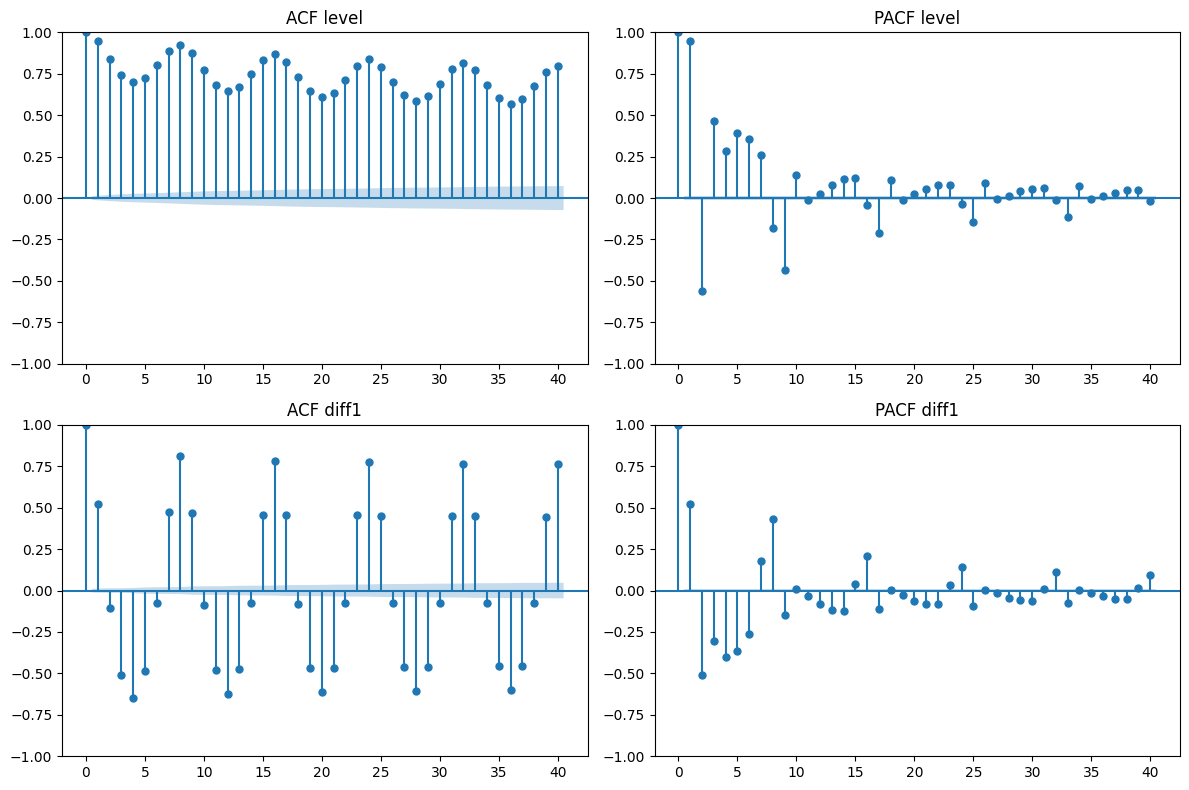

In [25]:
series = df['temperature_2m'].dropna()
diff1 = series.diff().dropna()

def run_stationarity_tests(x, label):
    adf_stat, adf_p, _, _, _, _ = adfuller(x, autolag='AIC')
    kpss_stat, kpss_p, _, _ = kpss(x, regression='c', nlags='auto')
    print(f"[{label}] ADF p-value={adf_p:.4f} (H0: unit root)")
    print(f"[{label}] KPSS p-value={kpss_p:.4f} (H0: stationarity)")
    print('-' * 60)

run_stationarity_tests(series, 'level')
run_stationarity_tests(diff1, 'diff1')

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(series, ax=axes[0,0], lags=40, title='ACF level')
plot_pacf(series, ax=axes[0,1], lags=40, title='PACF level', method='ywm')
plot_acf(diff1, ax=axes[1,0], lags=40, title='ACF diff1')
plot_pacf(diff1, ax=axes[1,1], lags=40, title='PACF diff1', method='ywm')
plt.tight_layout()

## Feature engineering (lags, rolling stats, time encodings)
Builds supervised table for ML models. Customize lags/rolling below.

In [26]:
feat_builder = FeatureBuilder(target_col='temperature_2m', time_col='date')
feature_df = feat_builder.build(df)
feature_df.head()

,temperature_2m,date,hour,dayofweek,month,sin_day,cos_day,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_lag_4,temperature_2m_lag_8,temperature_2m_roll_mean_2,temperature_2m_roll_mean_4,temperature_2m_roll_mean_8
0,10.130000,2014-01-02 00:00:00+00:00,0,3,1,0.000000e+00,1.000000e+00,9.796666,9.863333,10.230000,9.213333,5.563334,9.963333,10.005000,8.311250
1,9.546667,2014-01-02 03:00:00+00:00,3,3,1,7.071068e-01,7.071068e-01,10.130000,9.796666,9.863333,10.230000,4.863334,9.838334,9.834167,8.896667
2,8.763334,2014-01-02 06:00:00+00:00,6,3,1,1.000000e+00,6.123234e-17,9.546667,10.130000,9.796666,9.863333,4.980000,9.155000,9.559167,9.369583
3,8.863333,2014-01-02 09:00:00+00:00,9,3,1,7.071068e-01,-7.071068e-01,8.763334,9.546667,10.130000,9.796666,7.413333,8.813333,9.325833,9.550833
4,10.280000,2014-01-02 12:00:00+00:00,12,3,1,1.224647e-16,-1.000000e+00,8.863333,8.763334,9.546667,10.130000,9.213333,9.571667,9.363333,9.684167


## Train / test split (time-based)
Keep the last week (8 samples/day * 7 days = 56) as holdout for ML and ARIMA metrics.

In [27]:
train_df, test_df = train_test_split_time(feature_df, test_size=56)
y_train = train_df['temperature_2m']
y_test = test_df['temperature_2m']

# Series-only split for ARIMA/SARIMA
series_train, series_test = train_test_split_time(df[['temperature_2m']], test_size=56)

## ARIMA grid search (p,d,q)
Small search on MAE using the last 56 points as test. Adjust ranges if you have more compute time.

In [28]:
p_range = [0, 1, 2, 3]
d_range = [0, 1]
q_range = [0, 1, 2]
arima_results = []

for p, d, q in itertools.product(p_range, d_range, q_range):
    order = (p, d, q)
    try:
        model = ARIMAModel(order=order)
        model.fit(series_train)
        preds = model.predict(series_test)
        metrics = compute_metrics(series_test['temperature_2m'], preds)
        arima_results.append({"order": order, **metrics})
        print(f"ARIMA{order} -> MAE {metrics['mae']:.3f}")
    except Exception as exc:
        print(f"skip {order} ({exc})")

arima_results = sorted(arima_results, key=lambda x: x['mae'])
best_arima = arima_results[0] if arima_results else None
best_arima

ARIMA(0, 0, 0) -> MAE 8.320


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) -> MAE 6.783


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) -> MAE 6.167
ARIMA(0, 1, 0) -> MAE 5.579
ARIMA(0, 1, 1) -> MAE 5.553
ARIMA(0, 1, 2) -> MAE 5.547
ARIMA(1, 0, 0) -> MAE 5.581
ARIMA(1, 0, 1) -> MAE 5.562
ARIMA(1, 0, 2) -> MAE 5.577
ARIMA(1, 1, 0) -> MAE 5.574
ARIMA(1, 1, 1) -> MAE 5.551


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) -> MAE 5.446
ARIMA(2, 0, 0) -> MAE 5.661
ARIMA(2, 0, 1) -> MAE 5.597


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) -> MAE 5.356
ARIMA(2, 1, 0) -> MAE 5.521
ARIMA(2, 1, 1) -> MAE 5.436


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) -> MAE 5.509
ARIMA(3, 0, 0) -> MAE 5.502
ARIMA(3, 0, 1) -> MAE 5.326


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) -> MAE 5.401
ARIMA(3, 1, 0) -> MAE 5.499


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 1, 1) -> MAE 5.444


c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 1, 2) -> MAE 5.510


{'order': (3, 0, 1),
 'rmse': 6.013087904895967,
 'mae': 5.32638549310719,
 'mape': 546.051565734899}

## SARIMA grid search (p,d,q) x (P,D,Q,s)
Season length `s=8` (3h data -> 8 steps per day). Keep search tight to avoid long runtimes.

In [29]:
p_range = [0, 1, 2]
d_range = [0, 1]
q_range = [0, 1]
P_range = [0, 1]
D_range = [0, 1]
Q_range = [0, 1]
s = 8
sarima_results = []

for p, d, q in itertools.product(p_range, d_range, q_range):
    for P, D, Q in itertools.product(P_range, D_range, Q_range):
        order = (p, d, q)
        seasonal = (P, D, Q, s)
        try:
            model = SARIMAModel(order=order, seasonal_order=seasonal)
            model.fit(series_train)
            preds = model.predict(series_test)
            metrics = compute_metrics(series_test['temperature_2m'], preds)
            sarima_results.append({"order": order, "seasonal": seasonal, **metrics})
            print(f"SARIMA{order}x{seasonal} -> MAE {metrics['mae']:.3f}")
        except Exception as exc:
            print(f"skip {order}x{seasonal} ({exc})")

sarima_results = sorted(sarima_results, key=lambda x: x['mae'])
best_sarima = sarima_results[0] if sarima_results else None
best_sarima

SARIMA(0, 0, 0)x(0, 0, 0, 8) -> MAE 4.225
SARIMA(0, 0, 0)x(0, 0, 1, 8) -> MAE 3.982
SARIMA(0, 0, 0)x(0, 1, 0, 8) -> MAE 6.419
SARIMA(0, 0, 0)x(0, 1, 1, 8) -> MAE 6.309
SARIMA(0, 0, 0)x(1, 0, 0, 8) -> MAE 6.294
SARIMA(0, 0, 0)x(1, 0, 1, 8) -> MAE 6.221
SARIMA(0, 0, 0)x(1, 1, 0, 8) -> MAE 6.281
SARIMA(0, 0, 0)x(1, 1, 1, 8) -> MAE 6.863
SARIMA(0, 0, 1)x(0, 0, 0, 8) -> MAE 2.844
SARIMA(0, 0, 1)x(0, 0, 1, 8) -> MAE 4.815
SARIMA(0, 0, 1)x(0, 1, 0, 8) -> MAE 6.382
SARIMA(0, 0, 1)x(0, 1, 1, 8) -> MAE 6.396
SARIMA(0, 0, 1)x(1, 0, 0, 8) -> MAE 6.294
SARIMA(0, 0, 1)x(1, 0, 1, 8) -> MAE 6.344
SARIMA(0, 0, 1)x(1, 1, 0, 8) -> MAE 6.349
SARIMA(0, 0, 1)x(1, 1, 1, 8) -> MAE 6.810
SARIMA(0, 1, 0)x(0, 0, 0, 8) -> MAE 5.579
SARIMA(0, 1, 0)x(0, 0, 1, 8) -> MAE 5.583
SARIMA(0, 1, 0)x(0, 1, 0, 8) -> MAE 5.735
SARIMA(0, 1, 0)x(0, 1, 1, 8) -> MAE 5.792
SARIMA(0, 1, 0)x(1, 0, 0, 8) -> MAE 5.692
SARIMA(0, 1, 0)x(1, 0, 1, 8) -> MAE 5.775
SARIMA(0, 1, 0)x(1, 1, 0, 8) -> MAE 5.734
SARIMA(0, 1, 0)x(1, 1, 1, 8) -> MA

{'order': (0, 0, 1),
 'seasonal': (0, 0, 0, 8),
 'rmse': 3.678273736932151,
 'mae': 2.844343278793276,
 'mape': 225.20587289676186}

## SARIMAX with exogenous (time features)
Use best SARIMA order (if found) with calendar features as exogenous.

In [30]:
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype

exog_cols = [c for c in train_df.columns if c != "temperature_2m"]
y_train_sarimax = pd.to_numeric(train_df["temperature_2m"], errors="coerce").astype("float64")
y_test_sarimax  = pd.to_numeric(test_df["temperature_2m"], errors="coerce").astype("float64")

X_train = train_df[exog_cols].copy()
X_test  = test_df[exog_cols].copy()

# datetime -> features
for col in list(X_train.columns):
    if is_datetime64_any_dtype(X_train[col]) or col.lower() in {"date", "time", "timestamp"}:
        dt_train = pd.to_datetime(train_df[col], errors="coerce", utc=True)
        dt_test  = pd.to_datetime(test_df[col], errors="coerce", utc=True)

        X_train[f"{col}_hour"]  = dt_train.dt.hour
        X_train[f"{col}_dow"]   = dt_train.dt.dayofweek
        X_train[f"{col}_month"] = dt_train.dt.month

        X_test[f"{col}_hour"]   = dt_test.dt.hour
        X_test[f"{col}_dow"]    = dt_test.dt.dayofweek
        X_test[f"{col}_month"]  = dt_test.dt.month

        X_train = X_train.drop(columns=[col])
        X_test  = X_test.drop(columns=[col])

# bool -> int
for col in X_train.select_dtypes(include=["bool"]).columns:
    X_train[col] = X_train[col].astype("int64")
    X_test[col]  = X_test[col].astype("int64")

# object/strings -> numeric
X_train = X_train.apply(pd.to_numeric, errors="coerce").astype("float64")
X_test  = X_test.apply(pd.to_numeric, errors="coerce").astype("float64")

# NaN handling
X_train = X_train.ffill().bfill()
X_test  = X_test.ffill().bfill()

# align index
X_train = X_train.loc[y_train_sarimax.index]
X_test  = X_test.loc[y_test_sarimax.index]

if best_sarima:
    sarimax_order = best_sarima['order']
    sarimax_seasonal = best_sarima['seasonal']
else:
    sarimax_order = (1, 0, 1)
    sarimax_seasonal = (1, 1, 1, 8)

sarimax = SARIMAXModel(order=sarimax_order, seasonal_order=sarimax_seasonal)
sarimax.fit(pd.DataFrame({"temperature_2m": y_train_sarimax}), exog=X_train)
sarimax_pred = sarimax.predict(pd.DataFrame({"temperature_2m": y_test_sarimax}), exog=X_test)
sarimax_metrics = compute_metrics(y_test_sarimax, sarimax_pred)
sarimax_metrics

c:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'rmse': 5.9388042864567065,
 'mae': 5.302321552343322,
 'mape': 393.32589111630523}

## ML regressors with explicit lag grid
Build a richer lag table for linear regression, random forest, and gradient boosting.

In [37]:
ml_feat_builder = FeatureBuilder(
    target_col='temperature_2m',
    time_col='date',
    lags=[1, 2, 3, 4, 8, 16, 24],
    rolling_windows=[4, 8, 16],
)
ml_feature_df = ml_feat_builder.build(df)



ml_feature_df = ml_feature_df.copy()
ml_feature_df["date"] = pd.to_datetime(ml_feature_df["date"], utc=True, errors="coerce")

ml_feature_df["hour"] = ml_feature_df["date"].dt.hour
ml_feature_df["dow"] = ml_feature_df["date"].dt.dayofweek
ml_feature_df["month"] = ml_feature_df["date"].dt.month

# encodage cyclique (souvent meilleur en linreg)
import numpy as np
ml_feature_df["hour_sin"] = np.sin(2*np.pi*ml_feature_df["hour"]/24)
ml_feature_df["hour_cos"] = np.cos(2*np.pi*ml_feature_df["hour"]/24)
ml_feature_df["month_sin"] = np.sin(2*np.pi*ml_feature_df["month"]/12)
ml_feature_df["month_cos"] = np.cos(2*np.pi*ml_feature_df["month"]/12)

ml_feature_df = ml_feature_df.drop(columns=["date"])


In [38]:
ml_train, ml_test = train_test_split_time(ml_feature_df, test_size=56)
ml_y_train = ml_train["temperature_2m"]
ml_y_test = ml_test["temperature_2m"]
ml_feature_cols = [c for c in ml_feature_df.columns if c != "temperature_2m"]




In [39]:
# Linear Regression baseline
linreg = RegressionModel(regressor=LinearRegression(), feature_cols=ml_feature_cols)
linreg.fit(ml_train)
linreg_pred = linreg.predict(ml_test)
linreg_metrics = compute_metrics(ml_y_test, linreg_pred)
linreg_metrics

{'rmse': 4.9553662492345627e-14,
 'mae': 4.8704096311524836e-14,
 'mape': 3.9437060035694395e-12}

In [40]:
# Random Forest
rf = RegressionModel(feature_cols=ml_feature_cols)
rf.fit(ml_train)
rf_pred = rf.predict(ml_test)
rf_metrics = compute_metrics(ml_y_test, rf_pred)
rf_metrics

{'rmse': 0.46640975758467185,
 'mae': 0.3706937696045272,
 'mape': 27.230520649418143}

In [41]:
# Gradient Boosting
gbr = GradientBoostingModel(feature_cols=ml_feature_cols)
gbr.fit(ml_train)
gbr_pred = gbr.predict(ml_test)
gbr_metrics = compute_metrics(ml_y_test, gbr_pred)
gbr_metrics

{'rmse': 0.9895045972448475,
 'mae': 0.8215679977261308,
 'mape': 52.9890195908698}

## Prediction plots on validation window
Visual check of forecasts vs ground truth on the holdout window for ARIMA/SARIMA/SARIMAX and ML regressors.

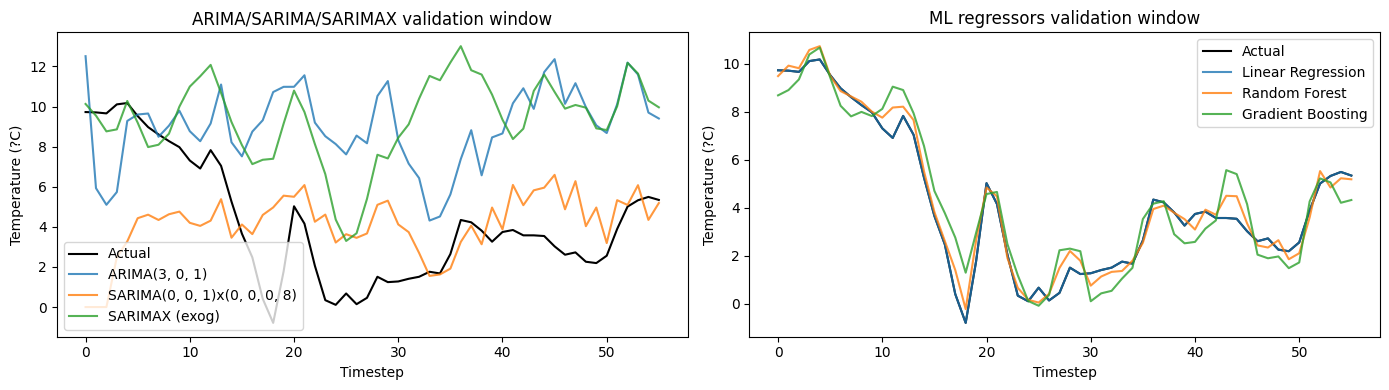

In [43]:
import matplotlib.pyplot as plt

# Ground truth for classical models (series split)
series_actual = series_test['temperature_2m'].reset_index(drop=True)
ts_preds = []
if 'best_arima' in globals() and best_arima:
    arima_best = ARIMAModel(order=best_arima['order'])
    arima_best.fit(series_train)
    arima_pred = arima_best.predict(series_test)
    ts_preds.append((f"ARIMA{best_arima['order']}", arima_pred))
if 'best_sarima' in globals() and best_sarima:
    sarima_best = SARIMAModel(order=best_sarima['order'], seasonal_order=best_sarima['seasonal'])
    sarima_best.fit(series_train)
    sarima_pred = sarima_best.predict(series_test)
    ts_preds.append((f"SARIMA{best_sarima['order']}x{best_sarima['seasonal']}", sarima_pred))
if 'sarimax_pred' in globals():
    ts_preds.append(("SARIMAX (exog)", sarimax_pred))

# Ground truth for ML models (lagged frame split)
ml_actual = ml_y_test.reset_index(drop=True)
ml_preds = []
if 'linreg_pred' in globals():
    ml_preds.append(("Linear Regression", linreg_pred))
if 'rf_pred' in globals():
    ml_preds.append(("Random Forest", rf_pred))
if 'gbr_pred' in globals():
    ml_preds.append(("Gradient Boosting", gbr_pred))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(series_actual.values, label='Actual', color='black')
for name, preds in ts_preds:
    axes[0].plot(range(len(series_actual)), preds[:len(series_actual)], label=name, alpha=0.8)
axes[0].set_title('ARIMA/SARIMA/SARIMAX validation window')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Temperature (?C)')
axes[0].legend()

axes[1].plot(ml_actual.values, label='Actual', color='black')
for name, preds in ml_preds:
    axes[1].plot(range(len(ml_actual)), preds[:len(ml_actual)], label=name, alpha=0.8)
axes[1].set_title('ML regressors validation window')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Temperature (?C)')
axes[1].legend()
plt.tight_layout()

## Residual analysis (example with best SARIMA)
Replace `sarima_pred` with the best-performing forecast to inspect errors.

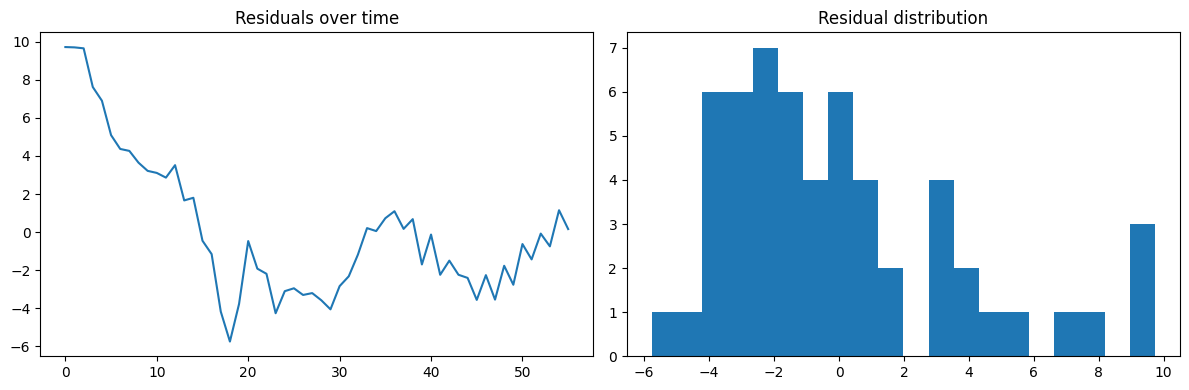

In [42]:
if best_sarima:
    sarima_best = SARIMAModel(order=best_sarima['order'], seasonal_order=best_sarima['seasonal'])
    sarima_best.fit(series_train)
    sarima_pred = sarima_best.predict(series_test)
    residuals = series_test['temperature_2m'] - sarima_pred
else:
    residuals = y_test - rf_pred  # fallback

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(ax=axes[0], title='Residuals over time')
axes[1].hist(residuals, bins=20)
axes[1].set_title('Residual distribution')
plt.tight_layout()